<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-osdc2020/blob/master/02_02_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Instead of training image classifiers from scratch, we can leverage pre-trained models in a process called Transfer Learning. 

The pre-trained model __does not__ predict the same classes as the model we are trying to build.

The intuition is that the pre-trained classifier has learned something about images in general, and we want to reuse that information in our own classifier without having to retrain it from scratch.

Typically this is done by replacing the __dense head__ of the pre-trained network with a __custom head__ that predicts one of our image classes.

The weights (W and b) in the custom head are initialized randomly as normal. But the rest of the weights (in the convolution part from the pre-trained model) are initialized with the weights of the pre-trained model.

Over the course of training, the weights will shift to adjust to the new objective. When we __freeze the weights__ of the pre-trained model during training and only allow the weights of our custom head to change, it is called __transfer learning__.

When we allow the weights of the pre-trained part to change during training, the process is called __fine tuning__. Fine tuning requires partially tuned components (both base and head), so should be done as a second step after transfer learning.

Here we will demonstrate transfer learning an [Xception network](https://arxiv.org/abs/1610.02357) to predict image classes for the CIFAR-10 dataset.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

## Data

In [ ]:
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)

ytrain = keras.utils.to_categorical(ytrain, num_classes=10)
ytest = keras.utils.to_categorical(ytest, num_classes=10)

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [ ]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer",
                  "dog", "frog", "horse", "ship", "truck"]

## Base Model

We download the Xception model (as-is, __with__ its prediction head) and try to run some predictions against it. Main idea here is to double check compatibility of our input with the model, i.e. any resizing and preprocessing considerations.

If you keep the top on, Xception expects an input size of (299, 299, 3) so we need to resize the input.

The `preprocess_input` applies some pixel offsets, removing the mean from each channel.

Input is an image of a frog, but Xception predicts 644 (matchstick) -- [full list of imagenet classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

base_model = Xception(weights="imagenet")

In [ ]:
input = image.smart_resize(Xtrain[0], (299, 299))
input = np.expand_dims(input, axis=0)
input = preprocess_input(input)
label = np.argmax(ytrain[0])

prediction = base_model.predict(input)
prediction = np.argmax(prediction)

print("input shape:", Xtrain[0].shape)
print("after preprocessing:", input.shape)

print("label:", label, cifar10_labels[label])
print("prediction:", prediction)

input shape: (32, 32, 3)
after preprocessing: (1, 299, 299, 3)
label: 6 frog
prediction: 926


Now download a head-less model, by setting `include_top=False`. 

Essentially this acts as a feature encoder, taking in the image and outputting a matrix of "features" (which is flattened to create a feature vector).

Good news is that we don't have to resize our image for a headless model.

In [ ]:
base_model = Xception(weights="imagenet", include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [ ]:
# model.summary()

In [ ]:
Xtrain = preprocess_input(Xtrain)
history = model.fit(Xtrain, ytrain, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 9s 15ms/step - loss: 1.9487 - accuracy: 0.3320 - val_loss: 1.7510 - val_accuracy: 0.3919
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 1.6753 - accuracy: 0.4119 - val_loss: 1.6914 - val_accuracy: 0.4005
Epoch 3/20
625/625 [==============================] - 9s 14ms/step - loss: 1.5937 - accuracy: 0.4403 - val_loss: 1.7528 - val_accuracy: 0.3954
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 1.5137 - accuracy: 0.4748 - val_loss: 1.6789 - val_accuracy: 0.4162
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 1.4443 - accuracy: 0.4991 - val_loss: 1.7367 - val_accuracy: 0.4181
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 1.3770 - accuracy: 0.5247 - val_loss: 1.8030 - val_accuracy: 0.4224
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 1.3085 - accuracy: 0.5500 - val_loss: 1.9101 - val_accuracy: 0.4176

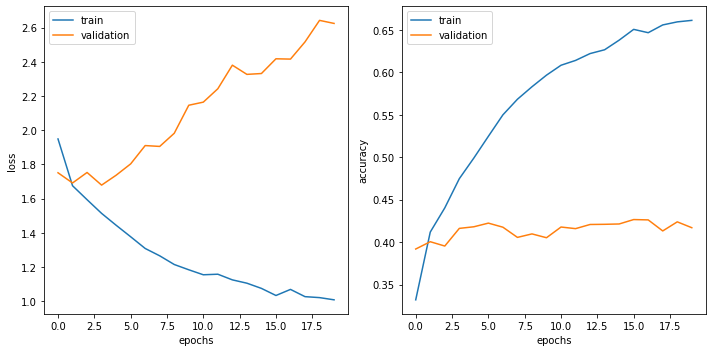

In [ ]:
def plot_training_curves(history):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history["val_loss"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(1, 2, 2)  
  plt.plot(history.history["accuracy"], label="train")
  plt.plot(history.history["val_accuracy"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")


  plt.tight_layout()
  _ = plt.show()

plot_training_curves(history)

In [ ]:
Xtest = preprocess_input(Xtest)
scores = model.evaluate(Xtest, ytest)
print("test set loss: {:.5f}, accuracy: {:.5f}".format(scores[0], scores[1]))

313/313 [==============================] - 3s 9ms/step - loss: 2.6954 - accuracy: 0.4181
test set loss: 2.69540, accuracy: 0.41810


Loss plots show that validation loss is rising and validation accuracy is flat, while the training loss and accuracy looks like what would be expected.

This indicates overfitting, probably because our dataset might be too small for the network size (network parameters are overfitting to the training data).

We have added BatchNorm and Dropout to help with this.


## Fine Tuning

Now that we have a partially trained model, let us try to fine tune our model starting from this.

We will retain the weights that we have learned so far, but in addition to the weights of the custom head, we will also __unfreeze__ the last 2 convolution blocks (which translates to the last 6 layers (conv + relu + batchnorm).


In [ ]:
# model.summary()

In [ ]:
# make last 6 layers (last 2 convolution blocks) trainable
for layer in base_model.layers[-6:]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 9s 15ms/step - loss: 0.9193 - accuracy: 0.6831 - val_loss: 2.5805 - val_accuracy: 0.4257
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9183 - accuracy: 0.6836 - val_loss: 2.5726 - val_accuracy: 0.4245
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9194 - accuracy: 0.6834 - val_loss: 2.5679 - val_accuracy: 0.4258
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9070 - accuracy: 0.6877 - val_loss: 2.5637 - val_accuracy: 0.4273
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9024 - accuracy: 0.6854 - val_loss: 2.5640 - val_accuracy: 0.4300
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.8986 - accuracy: 0.6885 - val_loss: 2.5592 - val_accuracy: 0.4264
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9027 - accuracy: 0.6870 - val_loss: 2.5614 - val_accuracy: 0.4285

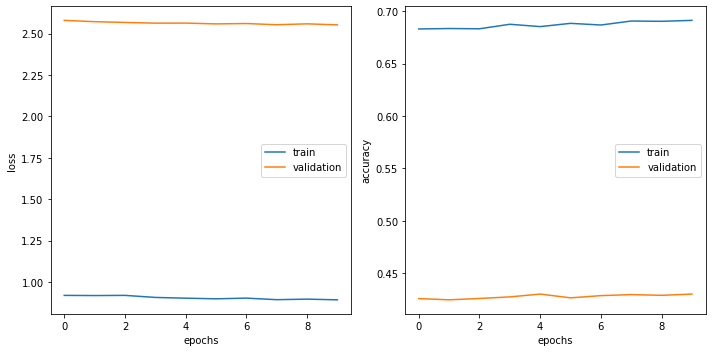

In [ ]:
plot_training_curves(history)

In [ ]:
scores = model.evaluate(Xtest, ytest)
print("test set loss: {:.5f}, accuracy: {:.5f}".format(scores[0], scores[1]))

313/313 [==============================] - 3s 9ms/step - loss: 2.6349 - accuracy: 0.4259
test set loss: 2.63489, accuracy: 0.42590
